# Import packages

In [1]:
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K
from keras.utils import to_categorical

from __future__ import division
from IPython.display import Audio,display
from collections import defaultdict
from PIL import Image

import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import pylab
import librosa, librosa.display
import itertools
import os
import re
import glob
import pandas as pd

os.getcwd()

/home/ubunt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'/home/ubunt/wav2mid/notebooks'

# Load Model

In [2]:
Adam = optimizers.Adam()

In [3]:
classifier = Sequential()

classifier.add(Conv2D(16, (3, 3), activation = 'relu',kernel_initializer='he_normal',input_shape = (224,224,3))) # 222 * 222
classifier.add(BatchNormalization())
classifier.add(Conv2D(16, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 220 * 220
classifier.add(BatchNormalization())
classifier.add(Conv2D(16, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 218 * 218
classifier.add(BatchNormalization())
classifier.add(Conv2D(16, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 216 * 216
classifier.add(BatchNormalization())

classifier.add(Conv2D(16, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 214 * 214
classifier.add(BatchNormalization())
classifier.add(Conv2D(88, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 212 * 212
classifier.add(BatchNormalization())
classifier.add(AveragePooling2D(pool_size=(106,106)))

classifier.add(Flatten())
classifier.add(Dense(units = 88, activation = 'sigmoid'))
classifier.compile(optimizer = Adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [4]:
weight_path = "/home/ubunt/wav2mid/data/weights/"
classifier.load_weights(weight_path + "w_88layer_pickle1_10_pickle2_10_pickle3_10_pickle4_10_pickle5_10_pickle6_10.hd5")

In [5]:
# Load best threshold
threshold_path = "/home/ubunt/wav2mid/threshold/"
best_threshold=pd.read_csv(threshold_path + '1109_best_threshold.csv'); best_threshold=np.array(best_threshold['0'])

# Load MP3

In [6]:
wav_path = "/home/ubunt/wav2mid/data/wav/"
y,sr = librosa.load(wav_path + 'summer.wav')
# Spectrogram size
size=(224,224)
# cqt 변환
D = librosa.cqt(y)

# envelope(음색,악기) 탐색
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# 눌린 위치 최고점 탐색
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv,backtrack=False)
# 눌린 위치 시작점 탐색
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# frame을 시간단위로 변환
onset_bt_time=librosa.frames_to_time(onset_bt)

In [7]:
# 5frame crop
inputs = []
for o in onset_bt:
    inputs.append(D[:,o:(o+5)])

In [8]:
# shape 변환
inputs = np.array(inputs)
inputs = np.swapaxes(inputs,1,2)

In [9]:
path = "/home/ubunt/wav2mid/data/test/summer/"

/home/ubunt/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '
/home/ubunt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


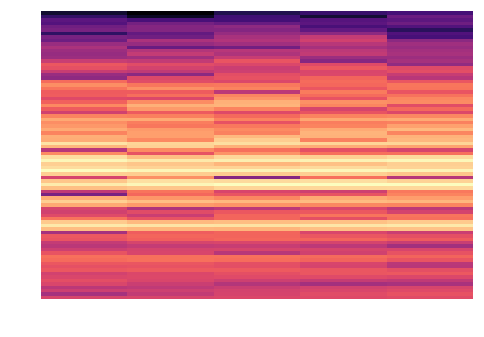

In [23]:
# spectrogram 저장
for i in range(inputs.shape[0]) :
    # 폴더 생성
    if not(os.path.isdir(path)):
        os.makedirs(os.path.join(path))
    
    # 시간순대로 저장하기 위함
    save_path = path + '{:04}'.format(i) + '.jpg'
        
    pylab.axis('off')
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(librosa.amplitude_to_db(inputs[i].T,ref=np.max), y_axis='cqt_note', x_axis='time', sr=sr)
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    image = Image.open(save_path)
    resize = image.resize(size)
    resize.save(save_path)
    image.close()
    resize.close()

In [10]:
from glob import glob

In [11]:
data=[]
# 시간순대로 불러오기
for file in sorted(glob(path + '/*.jpg')):
    img=Image.open(file)
    img=np.array(img)
    img=img.reshape(1,224,224,3)
    data.append(img)

In [12]:
# check
sorted(glob(path + '/*.jpg'))

['/home/ubunt/wav2mid/data/test/summer/0000.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0001.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0002.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0003.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0004.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0005.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0006.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0007.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0008.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0009.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0010.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0011.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0012.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0013.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0014.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0015.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0016.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0017.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0018.jpg',
 '/home/ubunt/wav2mid/data/test/summer/0019.jpg',


In [13]:
# 예측
predict=[]
for img in data:
    predict.append(classifier.predict_proba(img)[0])

In [14]:
# Thresholding
pitchs=[]
for i in predict:
    pred = i > best_threshold
    pitchs.append(np.where(pred==1)[0]+21)

In [15]:
# Midi program 설정
piano_midi = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)

In [17]:
# Midi 생성
for i, t in enumerate(onset_bt_time): # t: 시작, i+1: 끝 
    for j in pitchs[i]:
        try :
            note = pretty_midi.Note(velocity=100, pitch=j, start=t, end=onset_bt_time[i+1])
        except IndexError:
            # 마지막 음, 2초를 끌어줌
            note = pretty_midi.Note(velocity=100, pitch=j, start=t, end=t+2)
        piano.notes.append(note)

piano_midi.instruments.append(piano)
save_path = "/home/ubunt/wav2mid/final midi/"
piano_midi.write(save_path + '1109-summer.mid')